<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
    5.1. [Train-test split](#train_test_split)<br>
    5.2. [Fit a model to the data](#fit_model)<br>
    5.3. [Model evaluation](#model_evaluation)<br>
    5.4. [Fix problems](#fix_problems)
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest) -
      [Overfit](#overfit) - 
      [Underfit](#underfit)<br>
    7.3. [Gradient boosting](#gradient_boosting)<br>
    7.4. [Comparing algorithm performances](#comparing_algorithm_performances)
9. [Tuning](#tuning)<br>
    8.1. [Find best parameters](#find_best_parameters)<br>
    Bonus: [Classification](#classification)

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline

# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [3]:
taxi_jan_2019 = pd.read_parquet("data/yellow_tripdata_2019-01.parquet", engine="pyarrow")
taxi_data = pd.concat([taxi_jan_2019])

In [4]:
print(taxi_data.shape)
taxi_data.head()

(7696617, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In [5]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [6]:
taxi_data = taxi_data[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID','PULocationID',
       'DOLocationID', 'payment_type',  'total_amount']]

In [7]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55


array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>],
       [<Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

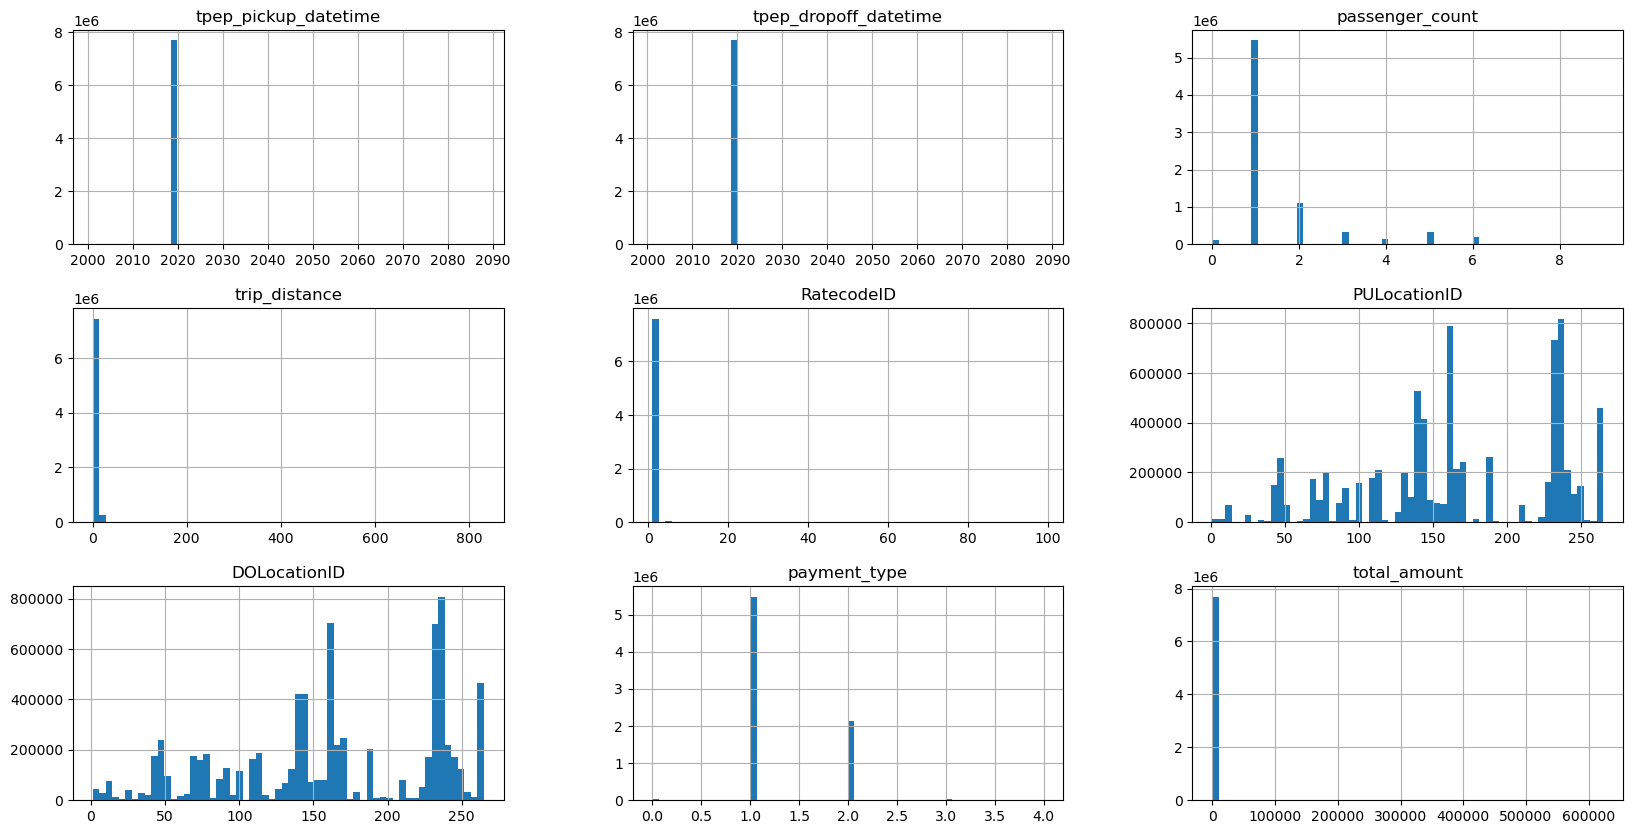

In [8]:
taxi_data.hist(figsize=(20,10), bins=60)

In [9]:
taxi_data['RatecodeID'].value_counts()

RatecodeID
1.0     7430288
2.0      166093
5.0       54570
3.0       11801
4.0        4895
99.0        252
6.0          46
Name: count, dtype: int64

<Axes: xlabel='index', ylabel='total_amount'>

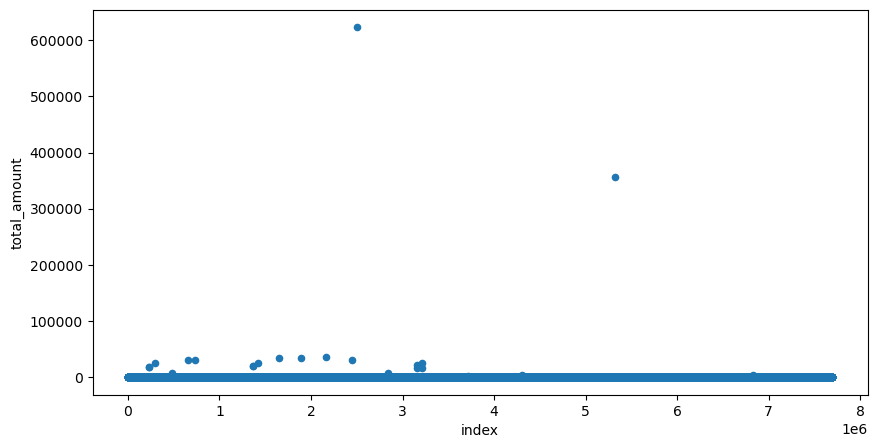

In [10]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

<Axes: xlabel='index', ylabel='total_amount'>

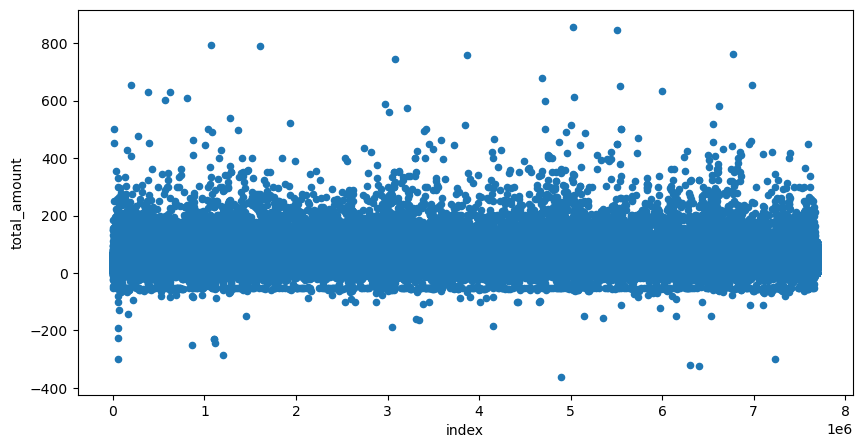

In [11]:
taxi_data[taxi_data['total_amount']<1000].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

Two things to deal with: negative values and very high values. Let's first look at negative values.

(7127, 9)


<Axes: xlabel='index', ylabel='total_amount'>

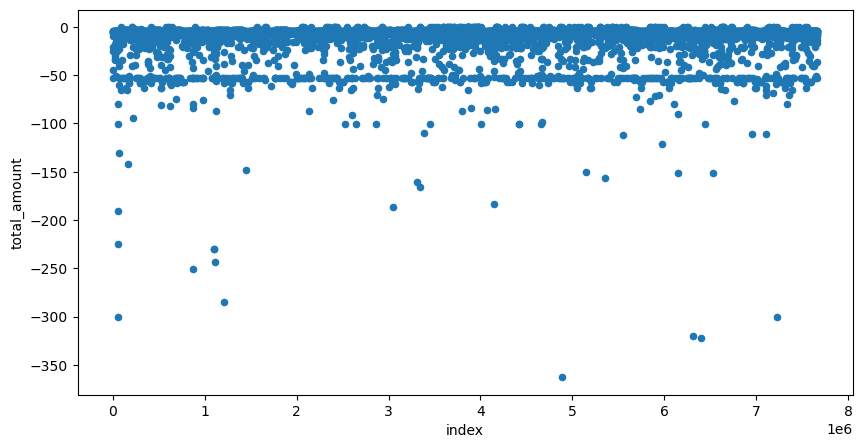

In [12]:
print(taxi_data[taxi_data['total_amount']<0].shape)
taxi_data[taxi_data['total_amount']<0].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))


In [13]:
taxi_data[taxi_data['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2.0,0.10,1.0,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1.0,4.13,1.0,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1.0,1.35,1.0,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1.0,0.00,1.0,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1.0,0.16,1.0,234,234,4,-4.3


In [14]:
taxi_data[taxi_data['total_amount']<0]['payment_type'].value_counts()

payment_type
3    4083
4    2667
2     376
1       1
Name: count, dtype: int64

<Axes: >

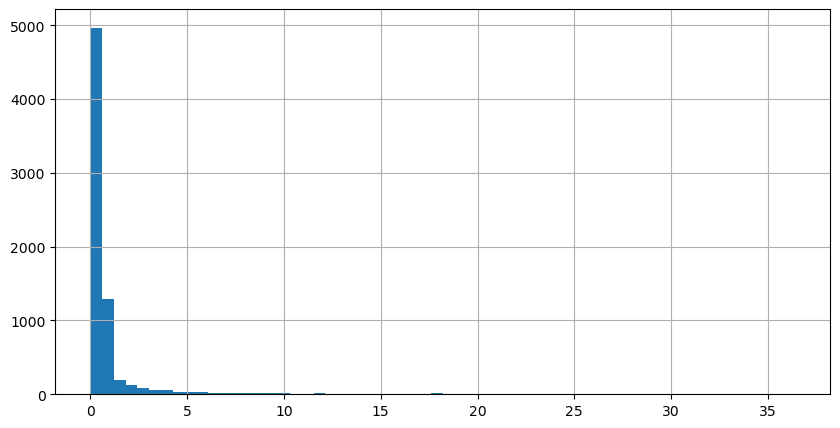

In [15]:
taxi_data[taxi_data['total_amount']<0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [16]:
print(taxi_data[taxi_data['total_amount']==0].shape)
taxi_data[taxi_data['total_amount']==0].head()

(1643, 9)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1.0,0.0,5.0,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1.0,0.0,5.0,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1.0,0.0,1.0,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1.0,0.0,1.0,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1.0,0.0,1.0,264,7,2,0.0


In [17]:
taxi_data[taxi_data['total_amount']==0]['payment_type'].value_counts()

payment_type
1    813
2    569
0    231
3     29
4      1
Name: count, dtype: int64

<Axes: >

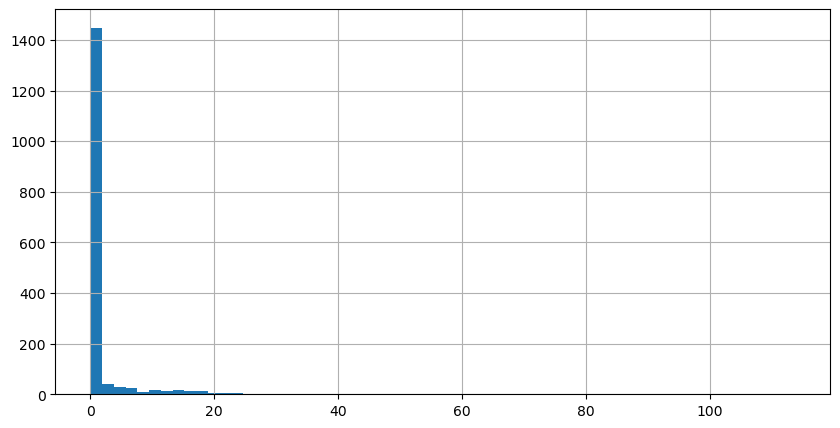

In [18]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [19]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].value_counts()

trip_distance
0.00     1323
0.03        9
0.01        8
0.06        6
1.00        4
         ... 
11.86       1
4.59        1
20.92       1
18.37       1
12.30       1
Name: count, Length: 256, dtype: int64

We can safely get rid of the negative values. What about the very high values?

<Axes: xlabel='index', ylabel='total_amount'>

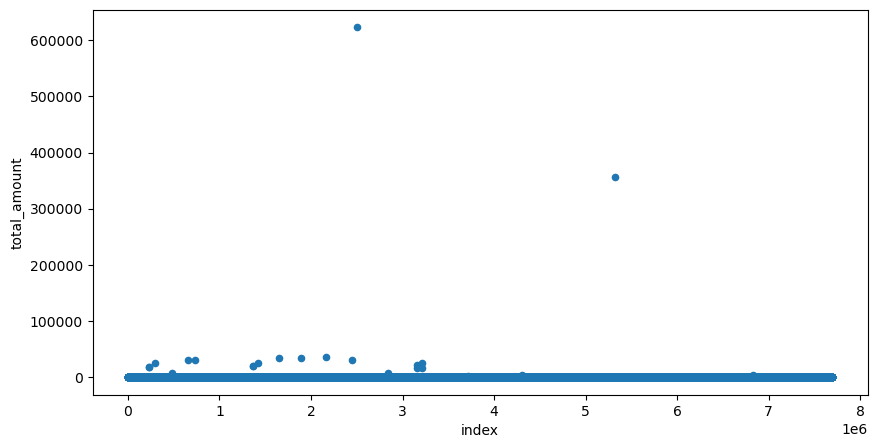

In [20]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [21]:
taxi_data[taxi_data['total_amount']>500].shape

(56, 9)

In [22]:
taxi_data[taxi_data['total_amount']>400].shape

(118, 9)

In [23]:
taxi_data[taxi_data['total_amount']>300].shape

(307, 9)

In [24]:
taxi_data[taxi_data['total_amount']>200].shape

(1166, 9)

In [25]:
taxi_data[taxi_data['total_amount']>100].shape

(10860, 9)

In [26]:
taxi_data['total_amount'].mean()

15.810651344610214

We can agree to cut from $200 level.

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [27]:
taxi_data_filtered = taxi_data[(taxi_data['total_amount']>=0)&(taxi_data['total_amount']<200)]

In [28]:
print(taxi_data.shape)
taxi_data_filtered.shape

(7696617, 9)


(7688319, 9)

Checking for missing values.

In [29]:
taxi_data_filtered.isna().sum()

tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          28672
trip_distance                0
RatecodeID               28672
PULocationID                 0
DOLocationID                 0
payment_type                 0
total_amount                 0
dtype: int64

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [30]:
taxi_data_prepared = taxi_data_filtered.copy()

Making sure everything is in the right type

In [31]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
total_amount                    float64
dtype: object

In [33]:
taxi_data_prepared.loc[:,'RatecodeID']   = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared.loc[:,'PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared.loc[:,'DOLocationID'] = taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared.loc[:,'payment_type'] = taxi_data_prepared['payment_type'].astype(str)

In [34]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

Transforming variables into the formats we need them

In [35]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55


In [36]:
taxi_data_prepared['transaction_date'] = pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime'].dt.date)
# -> we make it datetime again because it's very little use when it's just a string (can't compare, sort, etc.)
taxi_data_prepared['transaction_year'] = taxi_data_prepared['tpep_pickup_datetime'].dt.year
taxi_data_prepared['transaction_month'] = taxi_data_prepared['tpep_pickup_datetime'].dt.month
taxi_data_prepared['transaction_day'] =  taxi_data_prepared['tpep_pickup_datetime'].dt.day
taxi_data_prepared['transaction_hour'] = taxi_data_prepared['tpep_pickup_datetime'].dt.hour

In [37]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30,2019-01-01,2019,1,1,0
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80,2018-12-21,2018,12,21,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55,2018-11-28,2018,11,28,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55,2018-11-28,2018,11,28,15


array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'transaction_date'}>],
       [<Axes: title={'center': 'transaction_year'}>,
        <Axes: title={'center': 'transaction_month'}>,
        <Axes: title={'center': 'transaction_day'}>],
       [<Axes: title={'center': 'transaction_hour'}>, <Axes: >, <Axes: >]],
      dtype=object)

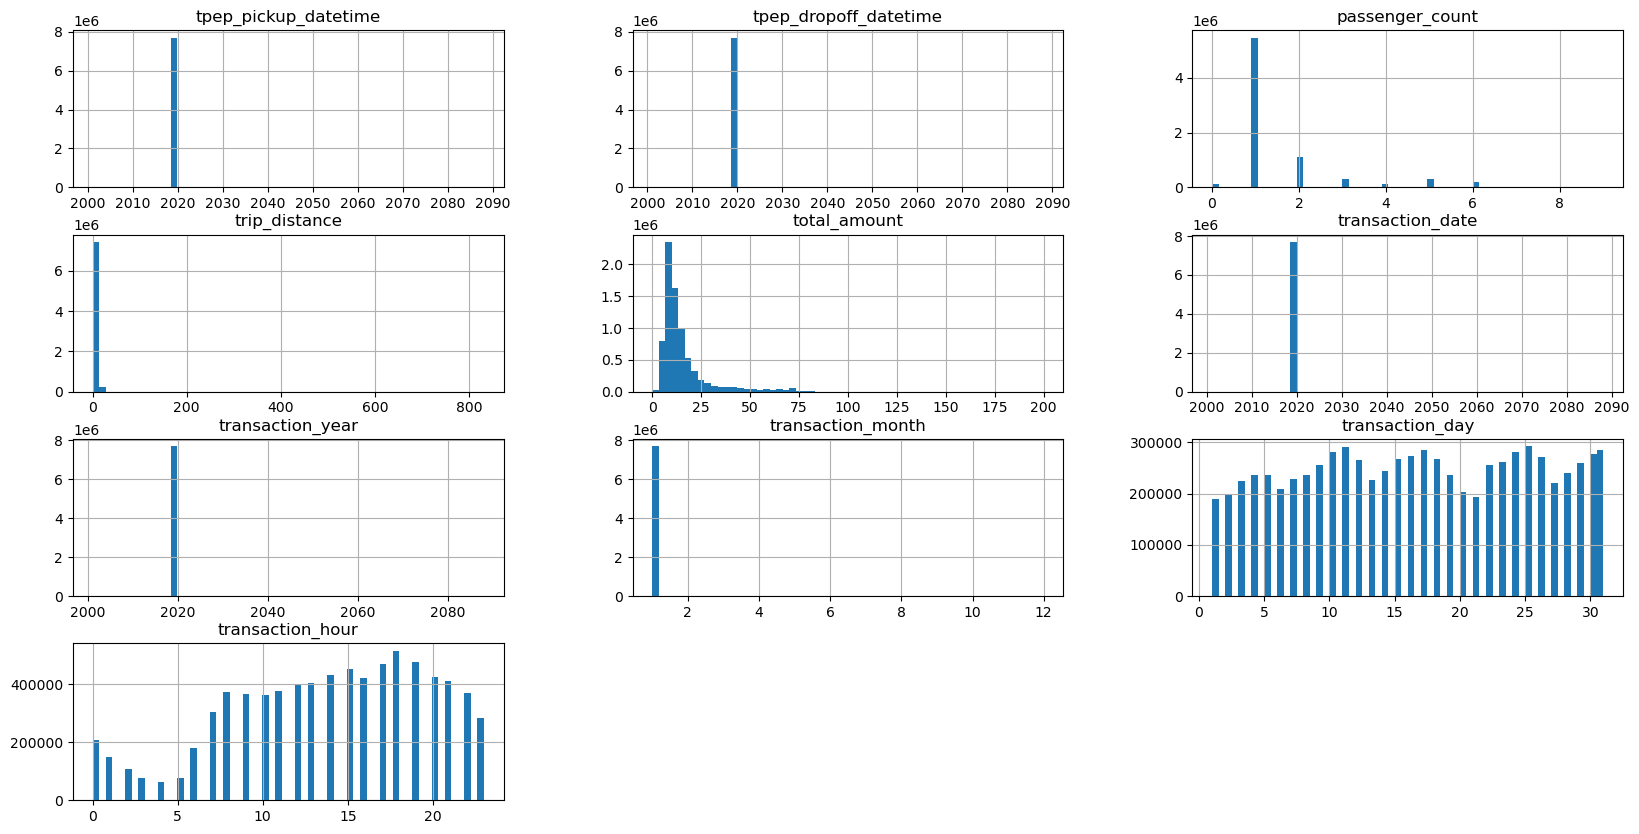

In [38]:
taxi_data_prepared.hist(figsize=(20,10), bins=60)

In [39]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_year']==2019]
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_month']==1]

Noting down categorical and numerical columns

In [41]:
categorical_columns = ['PULocationID','transaction_date','transaction_month','transaction_day','transaction_hour']
numerical_columns = ['trip_distance','total_amount']
all_needed_columns = categorical_columns + numerical_columns

In [42]:
main_taxi_df = taxi_data_prepared[all_needed_columns]
print(main_taxi_df.shape)
main_taxi_df.head()

(7687783, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,151,2019-01-01,1,1,0,1.5,9.95
1,239,2019-01-01,1,1,0,2.6,16.30
7,163,2019-01-01,1,1,0,1.3,9.05
8,229,2019-01-01,1,1,0,3.7,18.50
9,141,2019-01-01,1,1,0,2.1,13.00


Aggregate data points <br>
Now is a good time to think about what we want to predict. Depending on this, we need to transform our data to have a certain format.

In [43]:
taxi_grouped_by_region = main_taxi_df.groupby(categorical_columns).mean().reset_index()
taxi_grouped_by_region['count_of_transactions'] = main_taxi_df.groupby(categorical_columns).count().reset_index()['total_amount']
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()


(102713, 8)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


<Axes: >

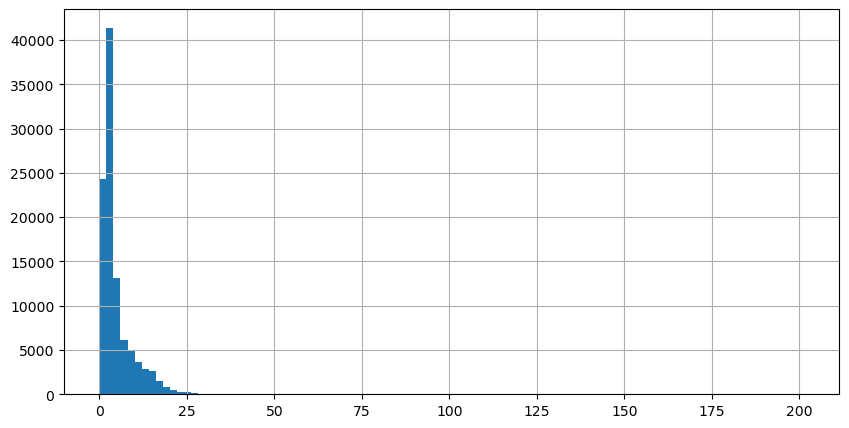

In [44]:
taxi_grouped_by_region['trip_distance'].hist(bins=100, figsize=(10,5))

<Axes: >

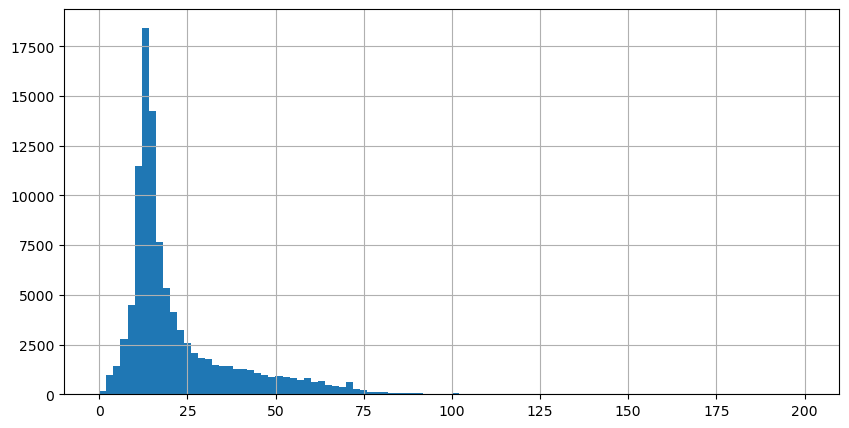

In [45]:
taxi_grouped_by_region['total_amount'].hist(bins=100, figsize=(10,5))

# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

In [60]:
data_for_benchmark_model = taxi_grouped_by_region.copy()

In [61]:
data_for_benchmark_model

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.00,21.800,1
1,1,2019-01-01,1,1,5,0.00,87.300,1
2,1,2019-01-01,1,1,6,0.00,80.300,1
3,1,2019-01-01,1,1,8,0.00,128.580,2
4,1,2019-01-01,1,1,10,16.90,43.245,4
...,...,...,...,...,...,...,...,...
102708,98,2019-01-31,1,31,18,16.66,58.060,1
102709,99,2019-01-18,1,18,18,1.66,9.800,1
102710,99,2019-01-26,1,26,8,0.42,6.000,1
102711,99,2019-01-30,1,30,7,2.87,18.050,1


In [62]:
categorical_features_benchmark = ['PULocationID','transaction_month','transaction_day','transaction_hour']
input_features_benchmark  = categorical_features_benchmark + ['trip_distance']
target_feature_benchmark  = 'total_amount'

In [63]:
data_for_benchmark_model.dtypes

PULocationID                     object
transaction_date         datetime64[ns]
transaction_month                 int32
transaction_day                   int32
transaction_hour                  int32
trip_distance                   float64
total_amount                    float64
count_of_transactions             int64
dtype: object

## 5.1. Train-test split <a id='train_test_split'></a>

In [64]:
from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode
# it converts the categorial object/string feature 'PULocationID' to creates a new binary column for each unique value in the original column.
# it does not convert the categorial numerical feature.
X_bench = pd.get_dummies(X_bench)


X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

In [65]:
X_bench.head()

,transaction_month,transaction_day,transaction_hour,trip_distance,PULocationID_1,PULocationID_10,PULocationID_100,PULocationID_101,PULocationID_102,PULocationID_104,...,PULocationID_90,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_94,PULocationID_95,PULocationID_96,PULocationID_97,PULocationID_98,PULocationID_99
0,1,1,2,0.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,1,5,0.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,1,6,0.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,1,8,0.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,1,10,16.9,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 5.2. Fit a model to the data <a id='fit_model'></a>

In [66]:
from sklearn.tree import DecisionTreeRegressor 

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

DecisionTreeRegressor(max_depth=10)

## 5.3. Model evaluation <a id='model_evaluation'></a>

In [68]:
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
print('r2', r2_score(y_test_b, y_pred_b))

mean_absolute_error 3.3811717555319127
mean_squared_error 61.307072367608356
root_mean_squared_error 7.829883292080946
r2 0.7916527171858228


* Mean Absolute Error (MAE)

Value: 3.4313471447309563

Definition: The Mean Absolute Error is the average of the absolute differences between the predicted values and the actual values.

Interpretation: It gives you an idea of how much the predictions deviate from the actual values on average. A lower MAE indicates better model performance.

* Mean Squared Error (MSE)

Value: 64.2961971730041

Definition: The Mean Squared Error is the average of the squared differences between the predicted values and the actual values.
Interpretation: MSE penalizes larger errors more than smaller ones because the errors are squared. A lower MSE indicates better model performance.

* Root Mean Squared Error (RMSE)

Value: 8.018490953602436

Definition: The Root Mean Squared Error is the square root of the Mean Squared Error.

Interpretation: RMSE is in the same units as the target variable, making it easier to interpret. It also penalizes larger errors more heavily. A lower RMSE indicates better model performance.

* R-squared (R²)

Value: 0.7705552174199464

Definition: R-squared is the proportion of the variance in the dependent variable that is predictable from the independent variables.

Interpretation: R² ranges from 0 to 1. An R² of 0.7705552174199464 means that approximately 77.06% of the variance in the target variable is explained by the model. A higher R² indicates a better fit of the model to the data.

* Summary

MAE: Average absolute error (lower is better).

MSE: Average squared error (lower is better).

RMSE: Square root of the average squared error (lower is better).

R²: Proportion of variance explained by the model (higher is better).

<Axes: xlabel='true', ylabel='pred'>

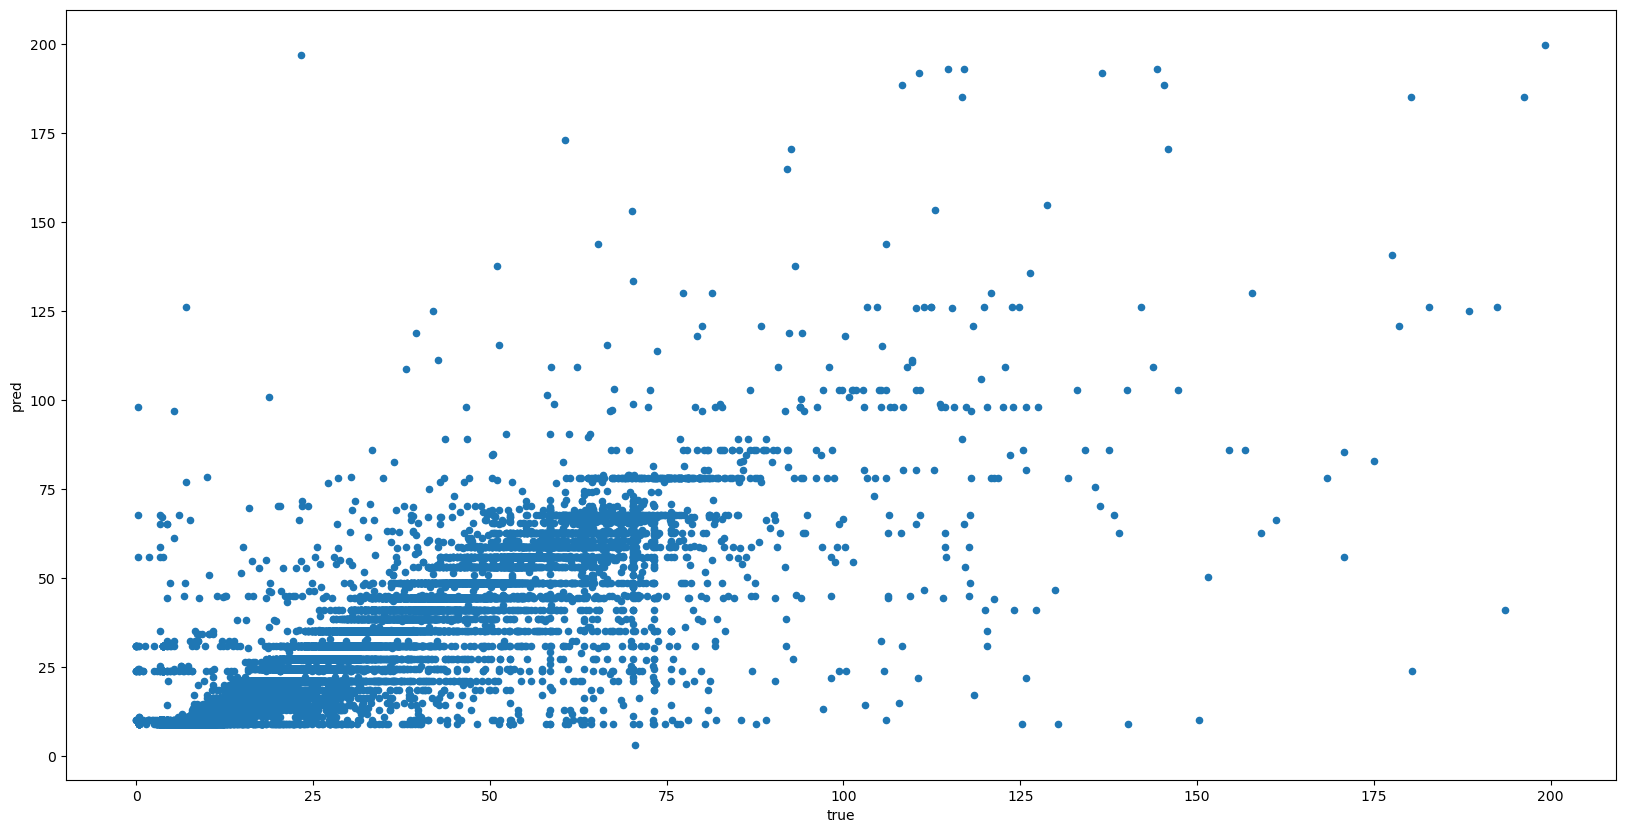

In [69]:
data = {'true': y_test_b, 'pred': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

Could this be too good to be true?

## 5.4. Fix problems <a id='fix_problems'></a>

In [70]:
categorical_features_benchmark = ['PULocationID','transaction_month','transaction_day','transaction_hour']
input_features_benchmark  = categorical_features_benchmark
target_feature_benchmark  = 'total_amount'

# Train and test split
from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

# Fit a model
from sklearn.tree import DecisionTreeRegressor 

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

# Evaluate model
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
print('r2', r2_score(y_test_b, y_pred_b))


mean_absolute_error 10.706155050433127
mean_squared_error 241.29173090787538
root_mean_squared_error 15.533567874376942
r2 0.17998895463899256


<Axes: xlabel='true', ylabel='pred'>

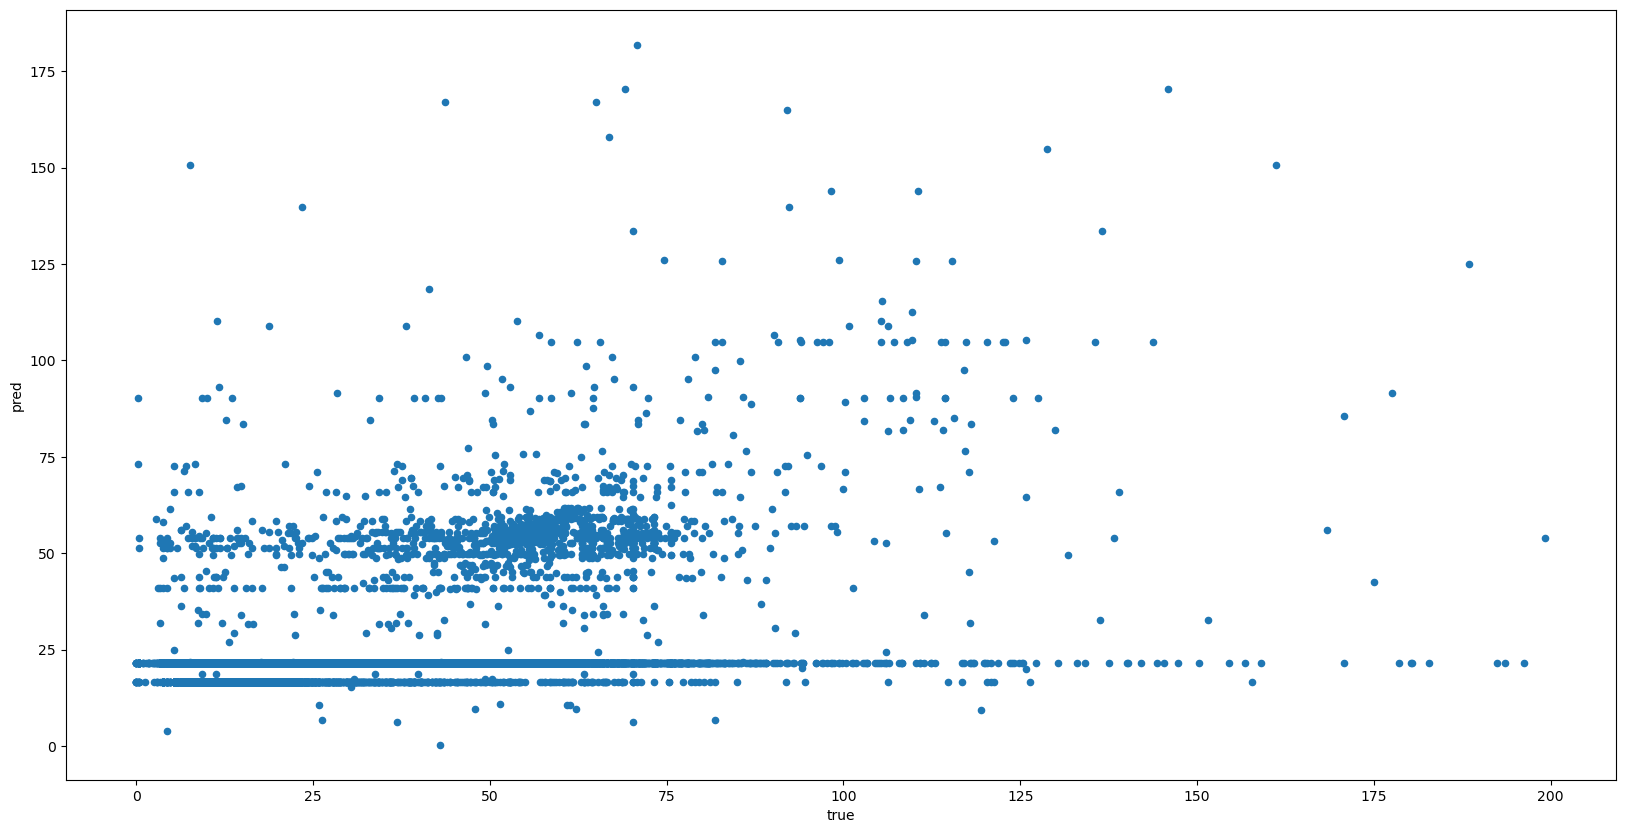

In [71]:
data = {'true': y_test_b, 'pred': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

In [72]:
taxi_grouped_by_region.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


In [73]:
data_with_new_features = taxi_grouped_by_region.copy()

**Date-related features**

In [74]:
data_with_new_features['transaction_week_day'] = data_with_new_features['transaction_date'].dt.weekday
data_with_new_features['weekend'] = data_with_new_features['transaction_week_day'].apply(lambda x: True if x == 5 or x == 6 else False)


In [76]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2018',
                        end='2020').date
data_with_new_features['is_holiday'] = data_with_new_features['transaction_date'].isin(holidays)

C:\Users\yangw\AppData\Local\Temp\ipykernel_16716\2463167083.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data_with_new_features['is_holiday'] = data_with_new_features['transaction_date'].isin(holidays)


In [77]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True


**Borough information**

In [78]:
zone_lookup = pd.read_csv('data/taxi_zone_lookup.csv')
zone_lookup = zone_lookup[['LocationID','Borough']]
zone_lookup['LocationID'] = zone_lookup['LocationID'].astype(str)
zone_lookup.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [79]:
data_with_new_features = data_with_new_features.merge(zone_lookup, left_on='PULocationID', right_on='LocationID', how='left')
data_with_new_features.drop('LocationID', axis=1, inplace=True)
data_with_new_features.head()


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,EWR
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,EWR
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,EWR
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,EWR
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,EWR


In [80]:
data_with_new_features['Borough'].value_counts()

Borough
Manhattan        45315
Brooklyn         23721
Queens           22000
Bronx             9649
Unknown            744
Staten Island      304
EWR                271
Name: count, dtype: int64

**Weather related features**

In [86]:
nyc_weather = pd.read_csv('data/nyc_weather.csv')
nyc_weather.head()

,time,temperature,precipitation,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection
0,2019-01-01T00:00,5.5,4.1,4.1,100,100,100,99,17.1,129
1,2019-01-01T01:00,6.2,2.6,2.6,100,100,100,100,20.7,129
2,2019-01-01T02:00,6.6,3.4,3.4,100,100,100,100,23.3,129
3,2019-01-01T03:00,7.2,3.9,3.9,100,100,100,100,26.3,131
4,2019-01-01T04:00,8.0,4.6,4.6,100,100,100,100,20.1,136


In [87]:
nyc_weather.shape

(744, 10)

There are some missing values and there are percentage values that we cannot work easily with. Let's look at them more closely.

In [88]:
nyc_weather.dtypes

time                object
temperature        float64
precipitation      float64
rain               float64
cloudcover           int64
cloudcover_low       int64
cloudcover_mid       int64
cloudcover_high      int64
windspeed_10m      float64
winddirection        int64
dtype: object

In [89]:
nyc_weather['cloudcover'].value_counts()

cloudcover
100    163
0      126
30      40
1       35
29      18
      ... 
77       1
38       1
64       1
24       1
41       1
Name: count, Length: 95, dtype: int64

In [90]:
nyc_weather['precipitation'].value_counts()

precipitation
0.0    645
0.1     22
0.2     12
0.5      6
1.6      6
0.4      4
0.3      4
0.9      3
2.2      3
1.5      3
0.7      2
3.1      2
1.9      2
1.1      2
1.0      2
0.6      2
3.8      2
2.3      2
2.0      2
3.2      2
4.8      2
0.8      1
1.8      1
1.7      1
2.5      1
4.1      1
2.8      1
2.6      1
2.1      1
2.4      1
1.4      1
4.6      1
3.9      1
3.4      1
3.3      1
Name: count, dtype: int64

In [91]:
nyc_weather.isna().sum()

time               0
temperature        0
precipitation      0
rain               0
cloudcover         0
cloudcover_low     0
cloudcover_mid     0
cloudcover_high    0
windspeed_10m      0
winddirection      0
dtype: int64

Trace of precipitation can be thought of as 0.1<br>
And the missing values 0

In [97]:
# nyc_weather['amount of precipitation'] = nyc_weather['amount of precipitation'].replace('Trace of precipitation', 0.1)
# nyc_weather['amount of precipitation'] = nyc_weather['amount of precipitation'].astype(float)

# option 1

# nyc_weather['amount of precipitation'].fillna(0, inplace=True)

# option 2 
# This uses the forward fill method (ffill) to fill missing values. 
# Forward fill propagates the last valid observation forward to the next valid observation.

# nyc_weather['amount of precipitation'].fillna(method='ffill', inplace=True)

# option 3 
# This method fills the missing values by interpolating between the existing values. 
# The default method is linear interpolation, which means it will estimate the missing values 
# by drawing a straight line between the known values.

# nyc_weather['amount of precipitation'].interpolate(inplace=True)

In [105]:
# nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('70 – 80%.', 0.7)
# nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('100%.', 1)
# nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('20–30%.', 0.3)
# nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('50%.', 0.5)
# nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('no clouds', 0)
# nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('Sky obscured by fog and/or other meteorological phenomena.', 1)
# nyc_weather['cloud cover'] = nyc_weather['cloud cover'].astype(float)
# nyc_weather['cloud cover'].interpolate(inplace=True)

In [92]:
nyc_weather.dtypes

time                object
temperature        float64
precipitation      float64
rain               float64
cloudcover           int64
cloudcover_low       int64
cloudcover_mid       int64
cloudcover_high      int64
windspeed_10m      float64
winddirection        int64
dtype: object

In [95]:
nyc_weather.loc[:,'date and time'] = pd.to_datetime(nyc_weather.loc[:,'time'])
nyc_weather['hour'] = nyc_weather['date and time'].dt.hour
nyc_weather['month'] = nyc_weather['date and time'].dt.month
nyc_weather['day'] = nyc_weather['date and time'].dt.day

In [96]:
nyc_weather.head()

,time,temperature,precipitation,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection,date and time,hour,month,day
0,2019-01-01T00:00,5.5,4.1,4.1,100,100,100,99,17.1,129,2019-01-01 00:00:00,0,1,1
1,2019-01-01T01:00,6.2,2.6,2.6,100,100,100,100,20.7,129,2019-01-01 01:00:00,1,1,1
2,2019-01-01T02:00,6.6,3.4,3.4,100,100,100,100,23.3,129,2019-01-01 02:00:00,2,1,1
3,2019-01-01T03:00,7.2,3.9,3.9,100,100,100,100,26.3,131,2019-01-01 03:00:00,3,1,1
4,2019-01-01T04:00,8.0,4.6,4.6,100,100,100,100,20.1,136,2019-01-01 04:00:00,4,1,1


In [98]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,EWR
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,EWR
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,EWR
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,EWR
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,EWR


In [103]:
nyc_taxi_with_weather = data_with_new_features.merge(nyc_weather, left_on = ['transaction_month','transaction_day','transaction_hour'], right_on = ['month','day','hour'], how='left')

print(nyc_taxi_with_weather.shape)
nyc_taxi_with_weather.head()


(102713, 26)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,...,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection,date and time,hour,month,day
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,...,100,100,100,100,23.3,129,2019-01-01 02:00:00,2,1,1
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,...,100,100,99,100,13.4,188,2019-01-01 05:00:00,5,1,1
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,...,100,100,100,100,14.8,219,2019-01-01 06:00:00,6,1,1
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,...,100,96,29,74,28.6,228,2019-01-01 08:00:00,8,1,1
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,...,94,92,1,36,28.8,244,2019-01-01 10:00:00,10,1,1


In [104]:
nyc_taxi_with_weather = nyc_taxi_with_weather.drop(['date and time','time','hour','month','day'], axis=1)


In [105]:
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,...,Borough,temperature,precipitation,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,...,EWR,6.6,3.4,3.4,100,100,100,100,23.3,129
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,...,EWR,8.8,2.0,2.0,100,100,99,100,13.4,188
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,...,EWR,9.3,0.5,0.5,100,100,100,100,14.8,219
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,...,EWR,12.7,0.0,0.0,100,96,29,74,28.6,228
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,...,EWR,13.9,0.0,0.0,94,92,1,36,28.8,244


In [106]:
nyc_taxi_with_weather.isna().sum()

PULocationID               0
transaction_date           0
transaction_month          0
transaction_day            0
transaction_hour           0
trip_distance              0
total_amount               0
count_of_transactions      0
transaction_week_day       0
weekend                    0
is_holiday                 0
Borough                  709
temperature                0
precipitation              0
rain                       0
cloudcover                 0
cloudcover_low             0
cloudcover_mid             0
cloudcover_high            0
windspeed_10m              0
winddirection              0
dtype: int64

In [114]:
# nyc_taxi_with_weather = nyc_taxi_with_weather.sort_values(['transaction_date','transaction_hour']).reset_index().drop('index',axis=1)

In [115]:
# nyc_taxi_with_weather = nyc_taxi_with_weather.interpolate()
# nyc_taxi_with_weather = nyc_taxi_with_weather.fillna(method='bfill')
# nyc_taxi_with_weather.isna().sum()

PULocationID               0
transaction_date           0
transaction_month          0
transaction_day            0
transaction_hour           0
trip_distance              0
total_amount               0
count_of_transactions      0
transaction_week_day       0
weekend                    0
is_holiday                 0
Borough                    0
temperature                0
humidity                   0
wind speed                 0
cloud cover                0
amount of precipitation    0
dtype: int64

In [107]:
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,...,Borough,temperature,precipitation,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,...,EWR,6.6,3.4,3.4,100,100,100,100,23.3,129
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,...,EWR,8.8,2.0,2.0,100,100,99,100,13.4,188
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,...,EWR,9.3,0.5,0.5,100,100,100,100,14.8,219
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,...,EWR,12.7,0.0,0.0,100,96,29,74,28.6,228
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,...,EWR,13.9,0.0,0.0,94,92,1,36,28.8,244


# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

In [117]:
data_for_model = nyc_taxi_with_weather.copy()

In [118]:
categorical_features = ['PULocationID', 'transaction_month', 'transaction_day',
       'transaction_hour', 'transaction_week_day', 'weekend', 'is_holiday', 'Borough']
input_features = categorical_features + ['temperature', 'humidity', 'wind speed', 'cloud cover',
       'amount of precipitation']
target_feature = 'total_amount'

### train-test split

In [119]:
from sklearn.model_selection import train_test_split

X = data_for_model[input_features]
y = data_for_model[target_feature]

# one-hot encode
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 7.1. Decision tree <a id='decision_tree'></a>

In [727]:
from sklearn.tree import DecisionTreeRegressor 

decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [728]:
model_at_hand = decision_tree

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 8.543263133212006
mean_squared_error 197.65100154101845
root_mean_squared_error 14.058840689794392
r2 0.3032678564604542


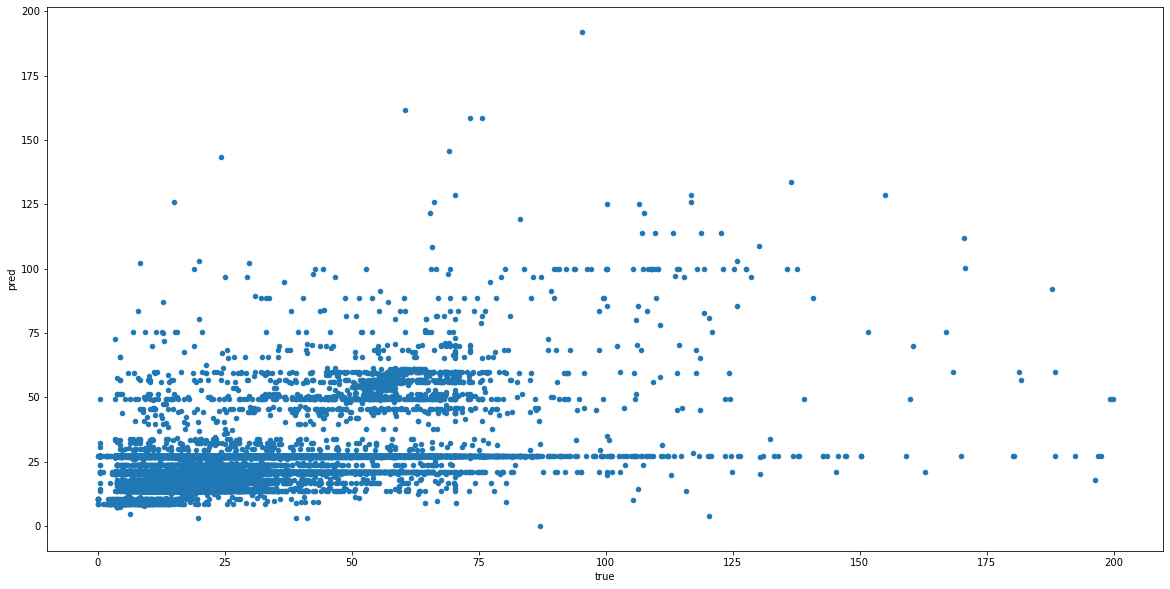

In [721]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

### Overfit <a id='overfit'></a>

The model fits the training data's pattern so much that it loses the ability to generalise.

In [724]:
X_train_overfit = X_train
y_train_overfit = y_train

X_test_overfit = X_test
y_test_overfit = y_test

In [725]:
rmse_scores = {'max_depth':[] ,'rmse_train':[], 'rmse_test':[]}

for md in [2, 5, 8, 10, 15, 20, 30, 50, 70, 100, 150]:
    print(md)
    decision_tree_overfit = DecisionTreeRegressor(max_depth=md)
    decision_tree_overfit.fit(X_train_overfit, y_train_overfit)
    
    model_at_hand_overfit = decision_tree_overfit
    
    y_pred_train = model_at_hand_overfit.predict(X_train_overfit)
    rmse_train = sqrt(mean_squared_error(y_train_overfit, y_pred_train))
    
    y_pred_test = model_at_hand_overfit.predict(X_test_overfit)
    rmse_test = sqrt(mean_squared_error(y_test_overfit, y_pred_test))
    
    rmse_scores['max_depth'].append(md)
    rmse_scores['rmse_train'].append(rmse_train)
    rmse_scores['rmse_test'].append(rmse_test)

2
5
8
10
15
20
30
50
70
100
150


In [731]:
pd.DataFrame.from_dict(rmse_scores)

,max_depth,rmse_train,rmse_test
0,2,1.495163e+01,15.174393
1,5,1.412253e+01,14.497210
2,8,1.352369e+01,14.112117
3,10,1.313962e+01,14.015107
4,15,1.204887e+01,14.318298
5,20,1.109997e+01,14.506965
6,30,9.498728e+00,15.044384
7,50,5.425101e+00,16.576495
8,70,1.124528e+00,17.336644
9,100,7.017987e-17,17.479575


Text(0, 0.5, 'root mean squared error')

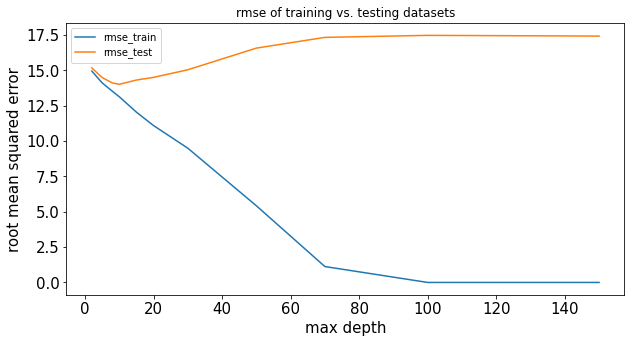

In [726]:
ax = pd.DataFrame.from_dict(rmse_scores).plot(figsize=(10,5),title="rmse of training vs. testing datasets", fontsize=15, x='max_depth')
ax.set_xlabel("max depth", fontsize=15)
ax.set_ylabel("root mean squared error", fontsize=15)

### Underfit <a id='underfit'></a>

Underfit is when the model cannot capture the data's pattern at all

In [732]:
X_train_underfit = X_train
y_train_underfit = y_train

X_test_underfit = X_test
y_test_underfit = y_test

In [733]:
decision_tree_underfit = DecisionTreeRegressor(max_depth=1)
decision_tree_underfit.fit(X_train_underfit, y_train_underfit)

# Training performance

model_at_hand_underfit = decision_tree_underfit

y_pred_underfit = model_at_hand_underfit.predict(X_train_underfit)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_train_underfit, y_pred_underfit))
print('mean_squared_error', mean_squared_error(y_train_underfit, y_pred_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_train_underfit, y_pred_underfit)))
print('r2', r2_score(y_train_underfit, y_pred_underfit))

mean_absolute_error 9.947300430991344
mean_squared_error 239.08086416457166
root_mean_squared_error 15.462239946546285
r2 0.12373835366276398


In [734]:
# Testing performance

y_pred_underfit = model_at_hand_underfit.predict(X_test_underfit)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_underfit, y_pred_underfit))
print('mean_squared_error', mean_squared_error(y_test_underfit, y_pred_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_underfit, y_pred_underfit)))
print('r2', r2_score(y_test_underfit, y_pred_underfit))

mean_absolute_error 10.08237412997993
mean_squared_error 249.2344278680739
root_mean_squared_error 15.787160221777503
r2 0.12143305210452982


## 7.2. Random forest <a id='random_forest'></a>

In [756]:
from sklearn.ensemble import RandomForestRegressor

rando_model = RandomForestRegressor()
rando_model.fit(X_train, y_train)

RandomForestRegressor()

In [762]:
model_at_hand = rando_model

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 7.434569774639803
mean_squared_error 175.08968855244223
root_mean_squared_error 13.232146029742955
r2 0.3827978959595716


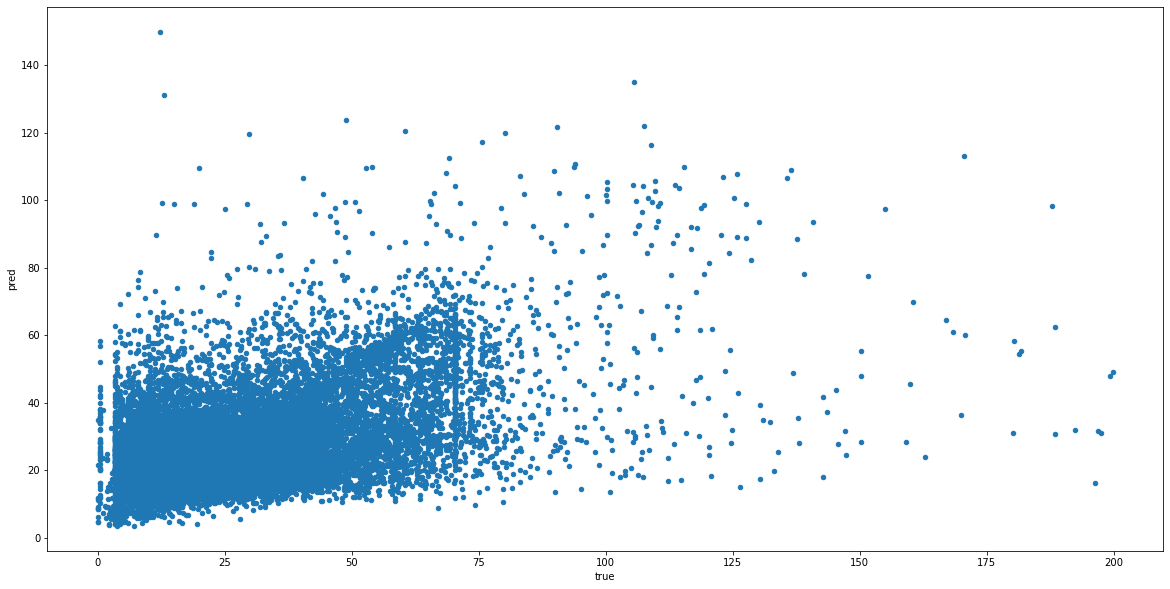

In [763]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## 7.3. Gradient boosting <a id='gradient_boosting'></a>

In [764]:
from sklearn.ensemble import GradientBoostingRegressor

gradBooster = GradientBoostingRegressor()
gradBooster.fit(X_train, y_train)

GradientBoostingRegressor()

In [769]:
model_at_hand = gradBooster

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 8.388198031970221
mean_squared_error 178.98089797962558
root_mean_squared_error 13.378374265194765
r2 0.369081139332866


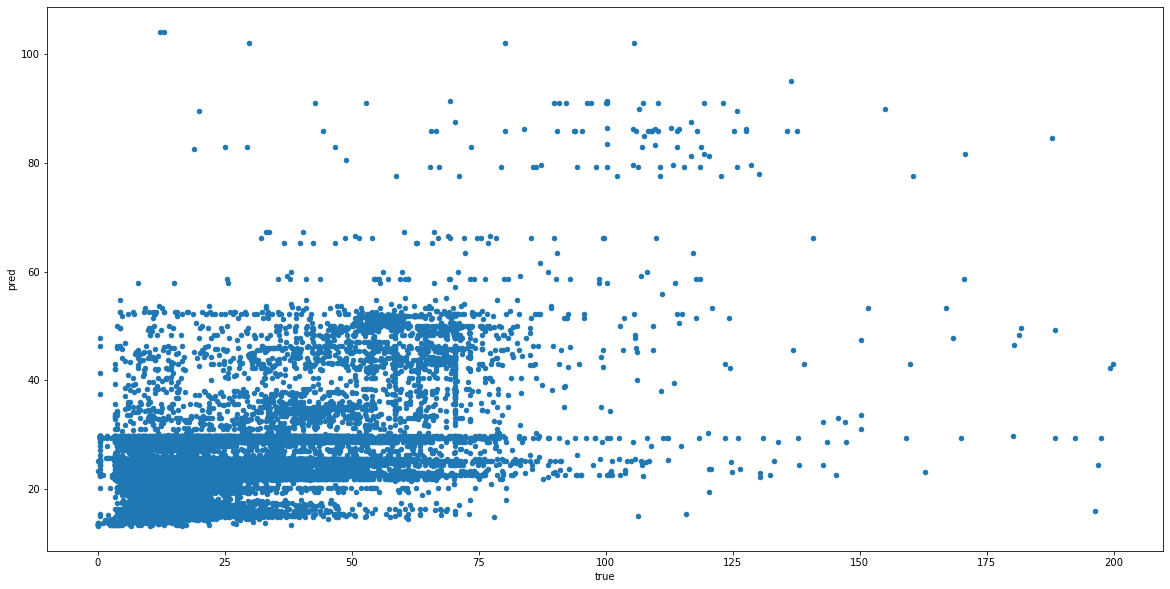

In [770]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

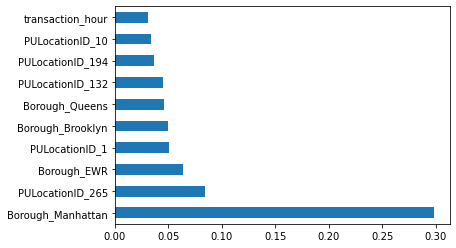

In [771]:
(pd.Series(model_at_hand.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')) 

## 7.4. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>

| Algorithm         |  MAE  |  RMSE  |   R2   |
|-------------------|:-----:|:------:|:------:|
| Benchmark model   | 9.778 | 14.739 |  0.225 |
| Decision tree     | 8.534 | 14.011 |  0.308 |
| Random forest     | 7.426 | 13.212 |  0.385 |
| Gradient boosting | 8.388 | 13.378 |  0.369 |

# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)

## 8.1. Find best parameters <a id='find_best_parameters'></a>

In [786]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,50,100,150,200,300,500]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [787]:
import pprint as pp

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 50, 100, 150, 200, 300, 500, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10, 20],
 'min_samples_split': [2, 5, 10, 20, 40],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [578]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

performances = pd.DataFrame.from_dict(rf_random.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 101.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 50, 100, 150, 200,
                                                      300, 500, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20, 40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [785]:
performances

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0,609.893916,4.279594,18.166433,0.101646,1000,10,1,sqrt,NaN,False,"{'n_estimators': 1000, 'min_samples_split': 10...",0.399992,0.413200,0.409462,0.407551,0.005559,4
1,1,85.114540,0.811083,3.300850,0.020019,200,10,2,sqrt,150.0,True,"{'n_estimators': 200, 'min_samples_split': 10,...",0.418440,0.434528,0.432045,0.428338,0.007072,2
2,2,2771.463416,71.988446,16.597484,0.328360,1000,2,2,auto,500.0,True,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.384569,0.395069,0.395788,0.391809,0.005128,6
3,3,551.652165,19.545405,3.278244,0.028908,200,10,2,auto,300.0,True,"{'n_estimators': 200, 'min_samples_split': 10,...",0.396363,0.409517,0.409461,0.405114,0.006187,5
4,4,5330.319429,171.608584,47.241538,2.772501,1200,5,1,auto,300.0,True,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.383322,0.391188,0.392000,0.388837,0.003913,7
5,5,3465.087614,1394.702060,15.411494,5.578977,600,2,2,auto,NaN,False,"{'n_estimators': 600, 'min_samples_split': 2, ...",0.048022,0.062129,0.058198,0.056116,0.005944,9
6,6,5711.335633,313.651271,15.013489,6.031182,1800,5,1,auto,10.0,False,"{'n_estimators': 1800, 'min_samples_split': 5,...",0.280892,0.277409,0.292584,0.283628,0.006490,8
7,7,18430.497320,1097.873528,169.645481,62.412614,2000,2,1,auto,100.0,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",-0.048452,-0.046208,-0.032492,-0.042384,0.007055,10
8,8,1097.998029,192.646829,43.957627,18.396754,1400,5,1,sqrt,50.0,True,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.409362,0.425126,0.422038,0.418842,0.006821,3
9,9,1866.890890,25.108106,69.483727,9.492094,1800,2,4,sqrt,300.0,True,"{'n_estimators': 1800, 'min_samples_split': 2,...",0.419014,0.435525,0.431126,0.428555,0.006981,1


In [781]:
import time
t0= time.time()

best = RandomForestRegressor(n_estimators=1800,min_samples_split= 2,
min_samples_leaf= 4,
max_features= 'sqrt',
max_depth= 300,
bootstrap= True)
best.fit(X_train, y_train)

t1 = time.time() - t0
print("Time elapsed: ", t1, " seconds")


model_at_hand = best

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

Time elapsed:  320.1432499885559  seconds
mean_absolute_error 7.415934165138361
mean_squared_error 161.17157508125337
root_mean_squared_error 12.695336745484672
r2 0.4318601165261371


In [784]:
from sklearn.ensemble import RandomForestRegressor

import time
t0= time.time()

second_best = RandomForestRegressor(n_estimators=200,min_samples_split= 10,
min_samples_leaf= 2,
max_features= 'sqrt',
max_depth= 150,
bootstrap= True)
second_best.fit(X_train, y_train)

t1 = time.time() - t0
print("Time elapsed: ", t1, " seconds")


model_at_hand = second_best

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

Time elapsed:  40.960970878601074  seconds
mean_absolute_error 7.337100268743273
mean_squared_error 160.32113137873418
root_mean_squared_error 12.661798110013214
r2 0.4348579837729314


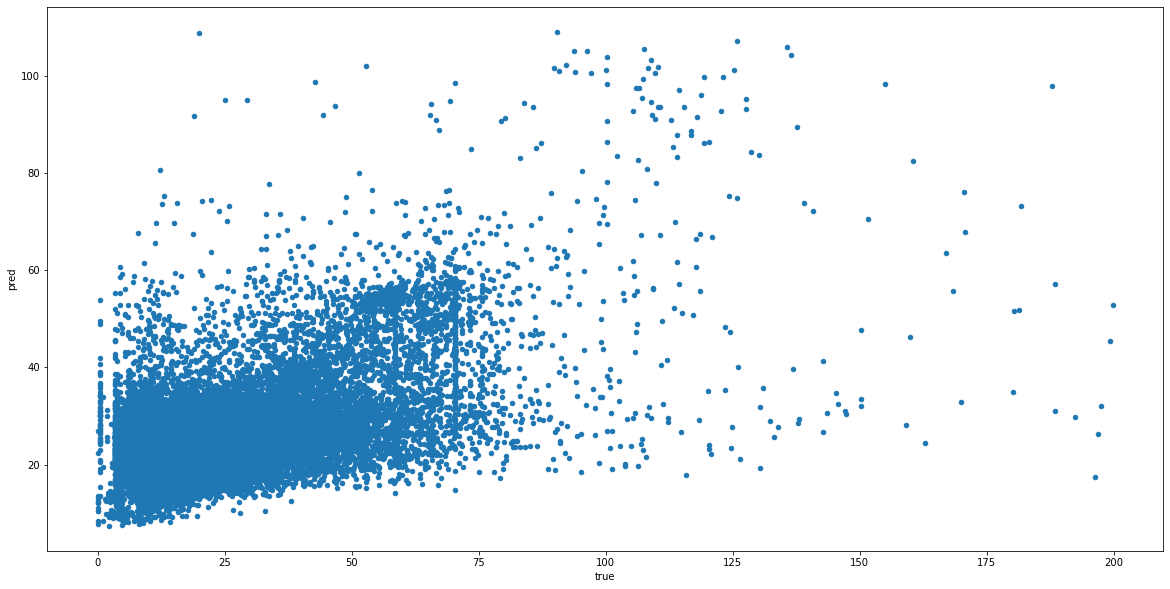

In [788]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## Bonus: Classification <a id='classification'></a>
[Back to top](#table_of_contents)

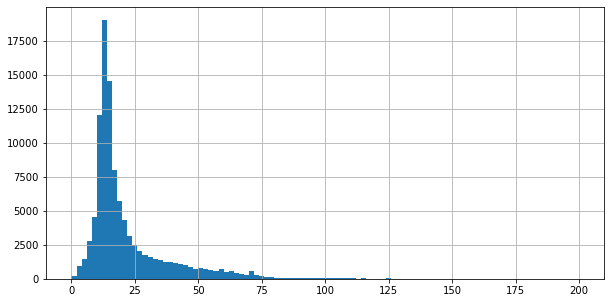

In [791]:
nyc_taxi_with_weather['total_amount'].hist(bins=100, figsize=(10,5))

In [792]:
nyc_class = nyc_taxi_with_weather.copy()
nyc_class['earning_class'] = nyc_taxi_with_weather['total_amount'].apply(lambda x: 'low' if x<=15 else 'high')
nyc_class['earning_class_binary'] = nyc_class['earning_class'].apply(lambda x: 0 if x=='low' else 1)
nyc_class.head()


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation,earning_class,earning_class_binary
0,10,2019-01-01,1,1,0,3.020000,14.300000,2,1,False,True,Queens,8.3,97.0,0.0,1.0,29.0,low,0
1,100,2019-01-01,1,1,0,2.801852,18.130000,54,1,False,True,Manhattan,8.3,97.0,0.0,1.0,29.0,high,1
2,106,2019-01-01,1,1,0,2.593333,15.373333,3,1,False,True,Brooklyn,8.3,97.0,0.0,1.0,29.0,high,1
3,107,2019-01-01,1,1,0,2.437458,14.897458,421,1,False,True,Manhattan,8.3,97.0,0.0,1.0,29.0,low,0
4,11,2019-01-01,1,1,0,1.795000,9.300000,2,1,False,True,Brooklyn,8.3,97.0,0.0,1.0,29.0,low,0


In [793]:
nyc_class['earning_class'].value_counts()

high    53099
low     49457
Name: earning_class, dtype: int64

In [794]:
categorical_features = ['PULocationID', 'transaction_month', 'transaction_day',
       'transaction_hour', 'transaction_week_day', 'weekend', 'is_holiday', 'Borough']
input_features = categorical_features + ['temperature', 'humidity', 'wind speed', 'cloud cover',
       'amount of precipitation']
target_feature = 'earning_class_binary'

In [795]:
from sklearn.model_selection import train_test_split

X_c = nyc_class[input_features]
y_c = nyc_class[target_feature]

# one-hot encode
X_c = pd.get_dummies(X_c)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.33, random_state=42)

In [796]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train_c, y_train_c)

y_pred_c = clf.predict(X_test_c)

In [797]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from math import sqrt

print(confusion_matrix(y_test_c, y_pred_c))

print('accuracy', accuracy_score(y_test_c, y_pred_c))
print('precision', precision_score(y_test_c, y_pred_c))
print('recall', recall_score(y_test_c, y_pred_c))

[[11367  5013]
 [ 3674 13790]]
accuracy 0.74332230232833
precision 0.733393607403074
recall 0.7896243701328447


In [ ]:
(pd.Series(clf.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')) 